In [1]:
from VaR import VaR

In [2]:
VaR = VaR.VaR(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31", VaR_level=0.05, window=1000)

[*********************100%***********************]  6 of 6 completed


In [3]:
VaR.calculate_VaR()

start:  0
end:  1000
start:  1
end:  1001
start:  2
end:  1002
start:  3
end:  1003
start:  4
end:  1004
start:  5
end:  1005
start:  6
end:  1006
start:  7
end:  1007
start:  8
end:  1008
start:  9
end:  1009
start:  10
end:  1010
start:  11
end:  1011
start:  12
end:  1012
start:  13
end:  1013
start:  14
end:  1014
start:  15
end:  1015
start:  16
end:  1016
start:  17
end:  1017
start:  18
end:  1018
start:  19
end:  1019
start:  20
end:  1020
start:  21
end:  1021
start:  22
end:  1022
start:  23
end:  1023
start:  24
end:  1024
start:  25
end:  1025
start:  26
end:  1026
start:  27
end:  1027
start:  28
end:  1028
start:  29
end:  1029
start:  30
end:  1030
start:  31
end:  1031
start:  32
end:  1032
start:  33
end:  1033
start:  34
end:  1034
start:  35
end:  1035
start:  36
end:  1036
start:  37
end:  1037
start:  38
end:  1038
start:  39
end:  1039
start:  40
end:  1040
start:  41
end:  1041
start:  42
end:  1042
start:  43
end:  1043
start:  44
end:  1044
start:  45
end:  104

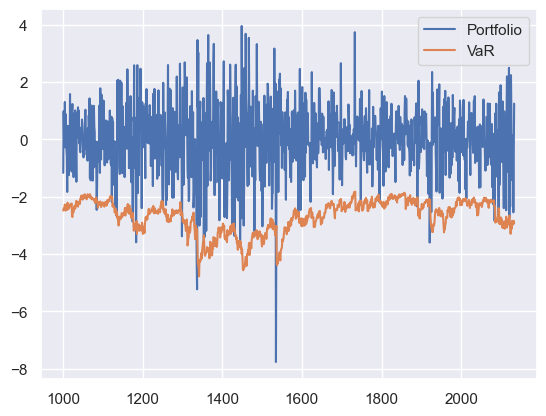

In [4]:
VaR.VaR_forecast.plot();

In [9]:
VaR.VaR_forecast[VaR.VaR_forecast['VaR']>VaR.VaR_forecast['Portfolio']].count()['VaR']

np.int64(24)

In [10]:
VaR.VaR_forecast.count()*0.05

Portfolio    56.65
VaR          56.65
dtype: float64

$x_t = \mu + \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

epsilon = copula werte